Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL  
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [2]:
## If you are using the data by mounting the google drive, use the following :
# from google.colab import drive
# drive.mount('/content/gdrive')

# Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('.\CNN_assignment_Original\SkincancerISICT\Train')
data_dir_test = pathlib.Path('.\CNN_assignment_Original\SkincancerISICT\Test')

In [4]:
# Count the number of images in train and test dataset
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Data Load

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [5]:
batch_size = 32
img_height = 180
img_width = 180

## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

In [6]:
#Visualize one instance of all the class present in the dataset.
from tensorflow.keras.preprocessing.image import load_img

train_ds_full = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),
                                                                    label_mode='categorical',seed=123)


Found 2239 files belonging to 9 classes.


Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your training and validation dataset here
train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=batch_size,
                                                               image_size=(img_height,img_width), label_mode='categorical',
                                                               seed=123,subset="both",
                                                               validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds_full.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualize one instance of all the nine classes present in the dataset

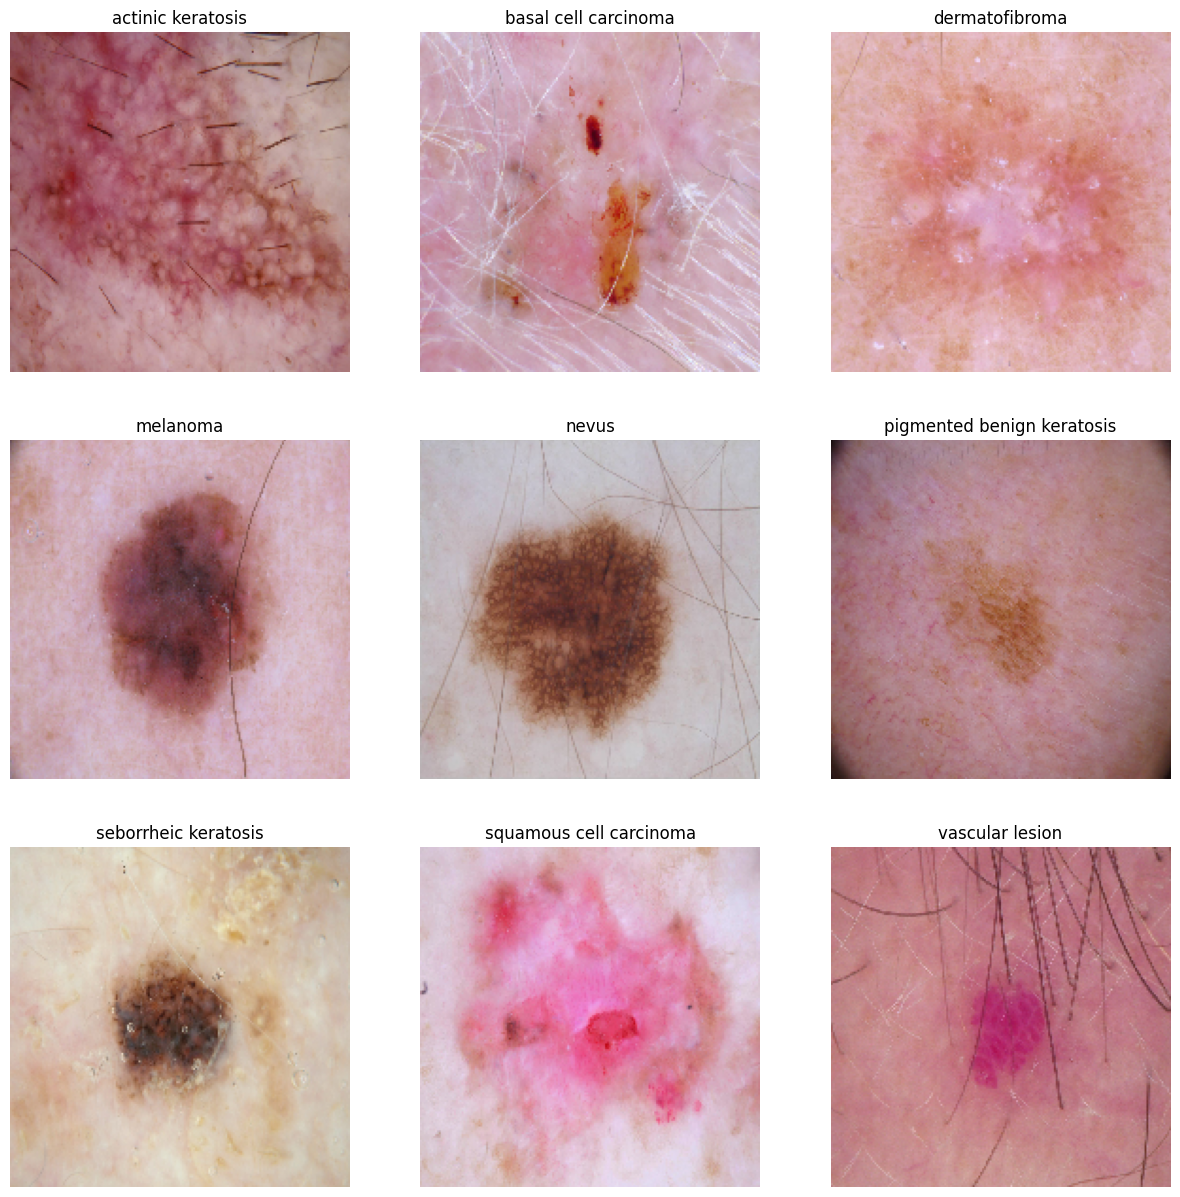

In [9]:
#all the classes of train dataset
class_names = train_ds_full.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Modelling Layer

 CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
import keras
from keras import layers

#### Model 1: Base CNN Model

In [12]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential([layers.Rescaling(1./255,input_shape=(img_height,img_width,3))])   #Rescaling Layer, 3 as images are RGB

#First Convulation layer for same batch size
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer, double the batch size
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer, quadraple the batch size
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dense Layer with softmax activation function.
#Softmax for multiclass classification, numbers/digits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

c:\Users\asthaagarwal\AppData\Local\anaconda3\envs\upgrad_new\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


##### Compile the model
Choose an appropirate optimiser and loss function for model training

In [13]:
#Adam optimization: Stochastic gradient descent method
#categorical_crossentropy: Used as a loss function for multi-class classification model.

model.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

#ModelCheckpoint to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

# Using early stopping to stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

##### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint,earlystop]
)

Epoch 1/20


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.2213 - loss: 2.2148
Epoch 1: val_accuracy improved from -inf to 0.26174, saving model to model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 56s 761ms/step - accuracy: 0.2216 - loss: 2.2116 - val_accuracy: 0.2617 - val_loss: 1.8820
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - accuracy: 0.3927 - loss: 1.7112
Epoch 2: val_accuracy improved from 0.26174 to 0.47427, saving model to model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 768ms/step - accuracy: 0.3933 - loss: 1.7100 - val_accuracy: 0.4743 - val_loss: 1.4887
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.4893 - loss: 1.4572
Epoch 3: val_accuracy improved from 0.47427 to 0.50559, saving model to model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 733ms/step - accuracy: 0.4893 - loss: 1.4574 - val_accuracy: 0.5056 - val_loss: 1.3941
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.5177 - loss: 1.3334
Epoch 4: val_accuracy improved from 0.50559 to 0.52573, saving m

##### Visualizing training results (Base Model)

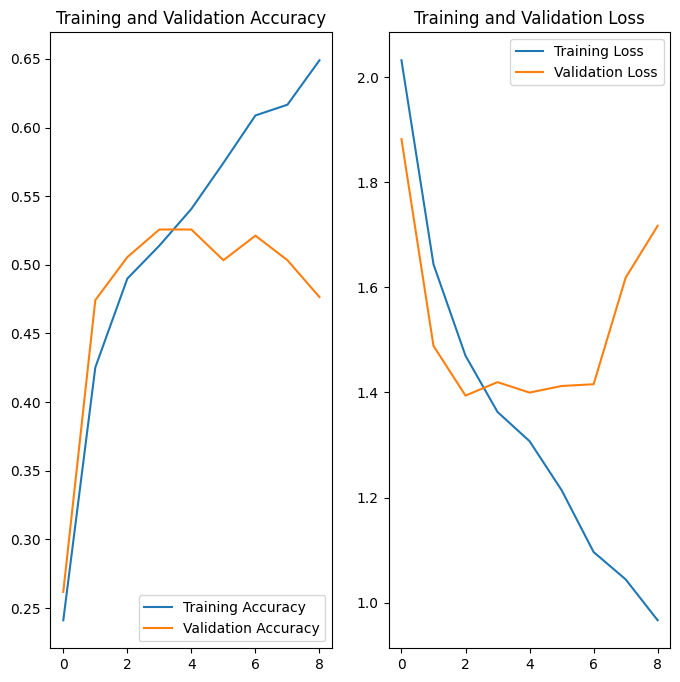

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(9)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### Findings:

- Difference in the trends of training and validation accuracy clearly shows the case of overfitting, the model performance the training loss is constantly decreasing but the validation loss is not.

- Also validation accuracy the model has achieved is below 65 %
Lets try applying techniques like Data Augmentation and Dropout to handle the overfitting issue of the model


#### Model 2: Modelling with Data Augmentation

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

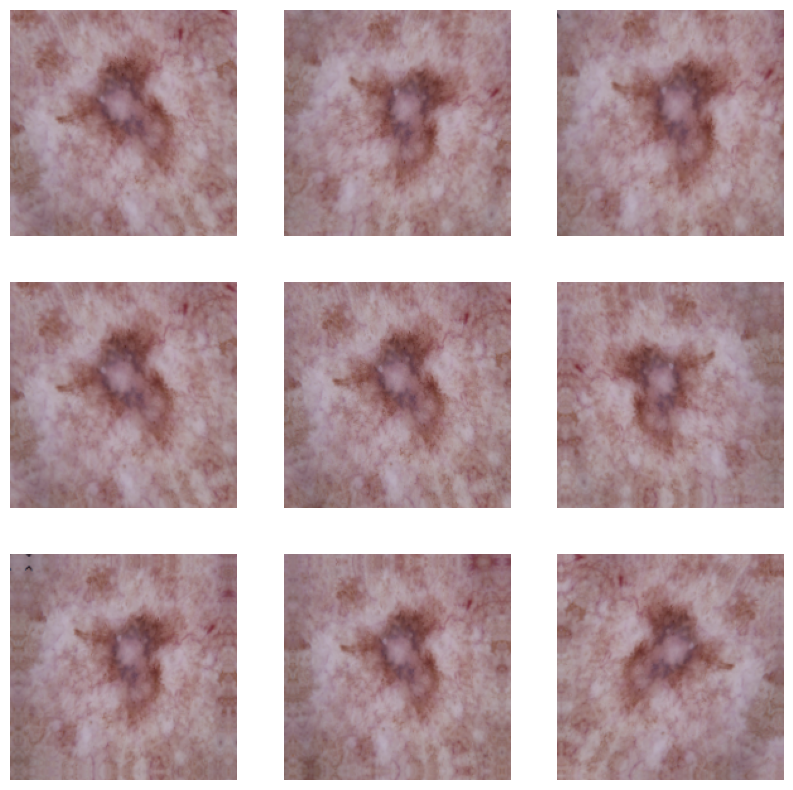

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

#### Model 2: With data augmentation layer

##### Training

In [21]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential([data_augmentation, layers.Rescaling(1./255,input_shape=(img_height,img_width,3))])   #Rescaling Layer, 3 as images are RGB

#First Convulation layer for same batch size
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer, double the batch size
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer, quadraple the batch size
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax for multiclass classification, numbers/digits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

##### Compile Model

In [22]:
# Compiling the model 

#Adam optimization: Stochastic gradient descent method
#categorical_crossentropy: Used as a loss function for multi-class classification model.

model.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

#ModelCheckpoint to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

# Using early stopping to stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [23]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

##### Train Model

In [24]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint,earlystop]
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.2127 - loss: 2.2147
Epoch 1: val_accuracy improved from -inf to 0.38479, saving model to model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 37s 623ms/step - accuracy: 0.2135 - loss: 2.2116 - val_accuracy: 0.3848 - val_loss: 1.8023
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - accuracy: 0.3888 - loss: 1.7496
Epoch 2: val_accuracy improved from 0.38479 to 0.46085, saving model to model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 780ms/step - accuracy: 0.3889 - loss: 1.7491 - val_accuracy: 0.4609 - val_loss: 1.5468
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - accuracy: 0.4547 - loss: 1.5590
Epoch 3: val_accuracy improved from 0.46085 to 0.49664, saving model to model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 813ms/step - accuracy: 0.4549 - loss: 1.5588 - val_accuracy: 0.4966 - val_loss: 1.5005
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.4603 - loss: 1.5355
Epoch 4: val_accuracy improved from 0.49664 to 0.5212

##### Visualizing the data

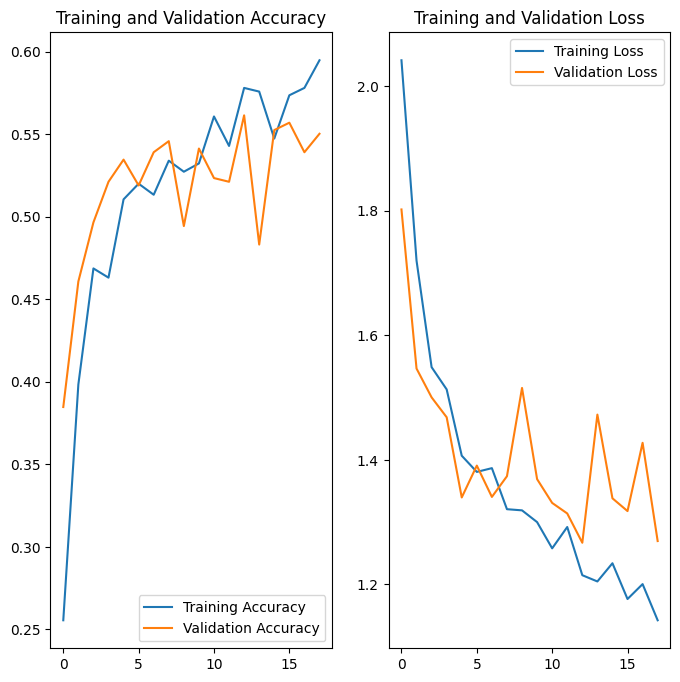

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(18)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Findings:
As the trend shows now the Training and Validation accuracies are in the same level and the highest accuracy achieved is around 57% , thus Data Augmentation can improve the model performance

Overfitting issue is also fading away due to data augmentation


#### Study distribution of classes in the training dataset.
 - In the current datasets there is a class imbalance, one class has proportionately higher number of samples compared to the others.

 - Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [27]:
# Analyze distribution of training dataset across various classes
def class_distribution_count(directory,subpath=""):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(str(directory)).iterdir():
        if path.is_dir():  
            count.append(len([name for name in os.listdir(str(path)+subpath)
                               if os.path.isfile(os.path.join(str(path)+subpath, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(str(directory))
                    if os.path.isdir(os.path.join(str(directory), name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


<Axes: xlabel='No. of Image', ylabel='Class'>

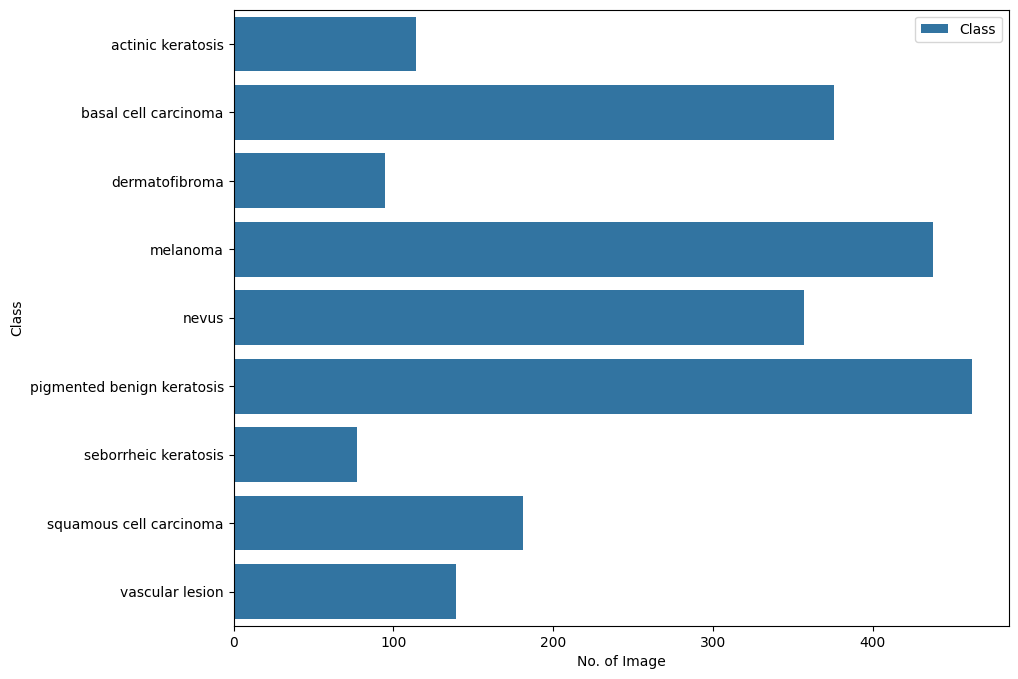

In [28]:
# Visualize data distribution by class
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

##### Findings:
 - seborrheic keratosis	class has the least number of samples
 - pigmented benign keratosis is dominating the data in terms proportionate number of samples


### Rectifying the class imbalance
Using a python package `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [76]:
!pip install Augmentor

^C


Found existing installation: Augmentor 0.2.12
Uninstalling Augmentor-0.2.12:
  Would remove:
    c:\users\asthaagarwal\appdata\local\anaconda3\envs\upgrad_new\lib\site-packages\augmentor-0.2.12.dist-info\*
    c:\users\asthaagarwal\appdata\local\anaconda3\envs\upgrad_new\lib\site-packages\augmentor\*
Proceed (Y/n)? 


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [87]:
path_to_training_dataset = pathlib.Path('.\CNN_assignment\SkincancerISICT\Train')
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset) + "/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to CNN_assignment\SkincancerISICT\Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1E8A6D35190>: 100%|██████████| 500/500 [00:08<00:00, 60.38 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to CNN_assignment\SkincancerISICT\Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1E882059390>: 100%|██████████| 500/500 [00:09<00:00, 55.00 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to CNN_assignment\SkincancerISICT\Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1E8A5C758D0>: 100%|██████████| 500/500 [00:08<00:00, 60.04 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to CNN_assignment\SkincancerISICT\Train/melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1E8A224B450>: 100%|██████████| 500/500 [00:43<00:00, 11.50 Samples/s] 


Initialised with 357 image(s) found.
Output directory set to CNN_assignment\SkincancerISICT\Train/nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x1E8A474D250>: 100%|██████████| 500/500 [00:41<00:00, 12.14 Samples/s]  


Initialised with 462 image(s) found.
Output directory set to CNN_assignment\SkincancerISICT\Train/pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1E8A223D690>: 100%|██████████| 500/500 [00:12<00:00, 41.00 Samples/s]


Initialised with 77 image(s) found.
Output directory set to CNN_assignment\SkincancerISICT\Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1E8F10121D0>: 100%|██████████| 500/500 [00:19<00:00, 25.10 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to CNN_assignment\SkincancerISICT\Train/squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1E8A4A9FB10>: 100%|██████████| 500/500 [00:08<00:00, 55.99 Samples/s]


Initialised with 139 image(s) found.
Output directory set to CNN_assignment\SkincancerISICT\Train/vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1E8A6D0EA10>: 100%|██████████| 500/500 [00:08<00:00, 57.77 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [90]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


#### Lets see the distribution of augmented data after adding new images to the original training data.

In [138]:
df2 = class_distribution_count(data_dir_train,"\output")

In [140]:
new_df = df._append(df2)

In [145]:
# Distribution of images after augmentation
new_df.groupby("Class").sum()

,No. of Image
Class,
actinic keratosis,614
basal cell carcinoma,876
dermatofibroma,595
melanoma,938
nevus,857
pigmented benign keratosis,962
seborrheic keratosis,577
squamous cell carcinoma,681
vascular lesion,639


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Model 3: Re-Train the model on the data created using Augmented Data

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

##### Reload a training and validation dataset

In [29]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('.\CNN_assignment\SkincancerISICT\Train')
data_dir_test = pathlib.Path('.\CNN_assignment\SkincancerISICT\Test')

In [30]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  label_mode='categorical', 
  batch_size=batch_size)

#Adding label_mode as categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [31]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  label_mode='categorical',
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Model 3: Create your model (make sure to include normalization)

In [32]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

c:\Users\asthaagarwal\AppData\Local\anaconda3\envs\upgrad_new\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [33]:
from tensorflow.keras.layers import BatchNormalization

In [52]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential([layers.Rescaling(1./255,input_shape=(img_height,img_width,3))])   #Rescaling Layer, 3 as images are RGB

#First Convulation layer for same batch size
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer, double the batch size
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
# model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer, quadraple the batch size
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
# model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax for multiclass classification, numbers/digits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

##### Compile your model

In [53]:
# Compiling the model 

#Adam optimization: Stochastic gradient descent method
#categorical_crossentropy: Used as a loss function for multi-class classification model.

model.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

#ModelCheckpoint to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

# Using early stopping to stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [54]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_8 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

##### Train your model

In [55]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint,earlystop]
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - accuracy: 0.1881 - loss: 2.1196
Epoch 1: val_accuracy improved from -inf to 0.39421, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 149s 865ms/step - accuracy: 0.1886 - loss: 2.1184 - val_accuracy: 0.3942 - val_loss: 1.6367
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.4069 - loss: 1.5610
Epoch 2: val_accuracy improved from 0.39421 to 0.49072, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 126s 741ms/step - accuracy: 0.4070 - loss: 1.5607 - val_accuracy: 0.4907 - val_loss: 1.3685
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.4785 - loss: 1.3813
Epoch 3: val_accuracy improved from 0.49072 to 0.50557, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 131s 769ms/step - accuracy: 0.4786 - loss: 1.3812 - val_accuracy: 0.5056 - val_loss: 1.2974
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.5250 - loss: 1.2509
Epoch 4: val_accuracy improved from 

##### Model 3: Visualize the model results

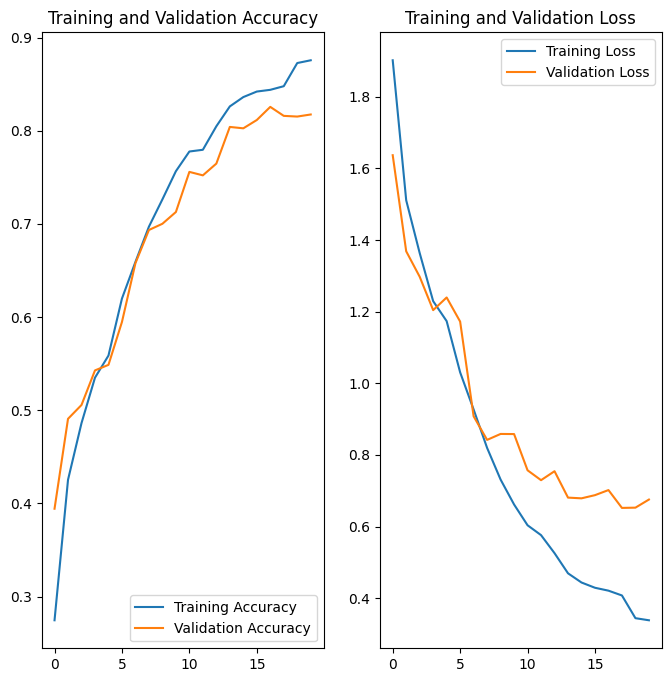

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### Model 3 Findings:

Did you get rid of underfitting/overfitting? - To some extent yes, but there is still overfitting effect on later epochs

Did class rebalance help? - Yes



#### Model prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Actual Class basal cell carcinoma
Predictive Class squamous cell carcinoma


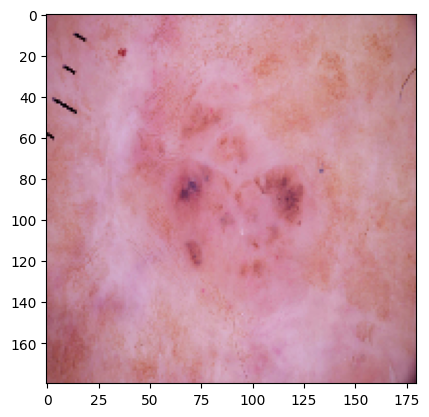

In [57]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )